In [63]:
%matplotlib inline

import pickle as pkl

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

column_labels = ['Lucky Star 1', 'Lucky Star 2', 'Ball 1', 'Ball 2', 'Ball 3', 'Ball 4', 'Ball 5']
column_indices = {name: i for i, name in enumerate(column_labels)}

Num GPUs Available:  1


In [2]:
df = pd.read_csv('euromillions-dataset.csv')
df

,Lucky Star 1,Lucky Star 2,Ball 1,Ball 2,Ball 3,Ball 4,Ball 5
0,4,5,6,20,22,24,45
1,2,7,9,11,13,21,32
2,5,7,2,6,14,19,23
3,5,8,3,23,24,34,35
4,2,5,10,15,31,41,42
...,...,...,...,...,...,...,...
166,6,9,1,19,36,38,49
167,9,10,10,25,29,34,45
168,2,4,6,16,18,39,47
169,7,12,5,14,35,36,39


In [35]:
diff_df = df.apply(lambda x: pd.concat([x, pd.Series([50])]).diff()[1:], axis=1,)
augmented_data = np.concatenate([df.values, diff_df.values], axis=1)
augmented_data

array([[ 4.,  5.,  6., ...,  2., 21.,  5.],
       [ 2.,  7.,  9., ...,  8., 11., 18.],
       [ 5.,  7.,  2., ...,  5.,  4., 27.],
       ...,
       [ 2.,  4.,  6., ..., 21.,  8.,  3.],
       [ 7., 12.,  5., ...,  1.,  3., 11.],
       [ 2.,  5.,  3., ...,  5.,  6., 20.]])

In [37]:
data_offset = 40
val_data = (augmented_data[:7] + data_offset) / (data_offset + 50)
test_data = (augmented_data[7:21] + data_offset) / (data_offset + 50)
train_data = (augmented_data[21:] + data_offset) / (data_offset + 50)
train_data

array([[0.52222222, 0.55555556, 0.52222222, ..., 0.46666667, 0.45555556,
        0.6       ],
       [0.45555556, 0.54444444, 0.48888889, ..., 0.45555556, 0.55555556,
        0.5       ],
       [0.5       , 0.51111111, 0.5       , ..., 0.51111111, 0.58888889,
        0.46666667],
       ...,
       [0.46666667, 0.48888889, 0.51111111, ..., 0.67777778, 0.53333333,
        0.47777778],
       [0.52222222, 0.57777778, 0.5       , ..., 0.45555556, 0.47777778,
        0.56666667],
       [0.46666667, 0.5       , 0.47777778, ..., 0.5       , 0.51111111,
        0.66666667]])

In [49]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.compat.v1.placeholder(tf.float32, (None, real_dim), name='input_real') 
    inputs_z = tf.compat.v1.placeholder(tf.float32, (None, z_dim), name='input_z') 
    
    return inputs_real, inputs_z

In [67]:
def generator(z, out_dim, n_units=14, reuse=False, alpha=0.01):
    with tf.compat.v1.variable_scope('generator', reuse=reuse):
        # Hidden layer
        h1 = tf.compat.v1.layers.dense(z, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(h1 * alpha, h1)
        
        # Logits and tanh output
        logits = tf.compat.v1.layers.dense(h1, out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out

In [68]:
def discriminator(x, n_units=14, reuse=False, alpha=0.01):
    with tf.compat.v1.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        h1 =  tf.compat.v1.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        logits = tf.compat.v1.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

## Hyperparameters

In [69]:
input_size = 14
# Size of latent vector to generator
z_size = 100
# Sizes of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128
# Leak factor for leaky ReLU
alpha = 0.01
# Label smoothing 
smooth = 0.1

## Build network

In [70]:
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
# Create our input placeholders
input_real, input_z = model_inputs(input_size, z_size)

# Generator network here
g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)
# g_model is the generator output

# Disriminator network here
d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)

/tmp/ipykernel_7806/2733179477.py:4: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h1 = tf.compat.v1.layers.dense(z, n_units, activation=None)
/tmp/ipykernel_7806/2733179477.py:9: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits = tf.compat.v1.layers.dense(h1, out_dim, activation=None)
/tmp/ipykernel_7806/2687986761.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits = tf.compat.v1.layers.dense(h1, 1, activation=None)


In [71]:
# Calculate losses
d_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                            labels=tf.ones_like(d_logits_real) * (1 - smooth)))

d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_real)))

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))

In [72]:
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.compat.v1.trainable_variables() 
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

## Training

In [88]:
batch_size = 50
epochs = 1000
samples = []
losses = []
saver = tf.compat.v1.train.Saver(var_list = g_vars)
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    for e in range(epochs):
        print((train_data.shape[0]//batch_size) - 1)
        for ii in range(3):
            batch = train_data[ii * batch_size: (ii+1) * batch_size]
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                        generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                        feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')


2023-10-20 22:55:54.107890: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-20 22:55:54.107952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-20 22:55:54.107970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-20 22:55:54.108135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-20 22:55:54.108159: I tensorflow/core/co

2
Epoch 1/1000... Discriminator Loss: 1.2132... Generator Loss: 0.6244
2
Epoch 2/1000... Discriminator Loss: 1.1812... Generator Loss: 0.6157


/tmp/ipykernel_7806/2733179477.py:4: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h1 = tf.compat.v1.layers.dense(z, n_units, activation=None)
/tmp/ipykernel_7806/2733179477.py:9: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits = tf.compat.v1.layers.dense(h1, out_dim, activation=None)


2
Epoch 3/1000... Discriminator Loss: 1.1785... Generator Loss: 0.6068
2
Epoch 4/1000... Discriminator Loss: 1.1407... Generator Loss: 0.6427
2
Epoch 5/1000... Discriminator Loss: 1.1028... Generator Loss: 0.6857
2
Epoch 6/1000... Discriminator Loss: 1.0556... Generator Loss: 0.7574
2
Epoch 7/1000... Discriminator Loss: 1.0267... Generator Loss: 0.8407
2
Epoch 8/1000... Discriminator Loss: 1.0887... Generator Loss: 0.8260
2
Epoch 9/1000... Discriminator Loss: 1.0601... Generator Loss: 0.9567
2
Epoch 10/1000... Discriminator Loss: 1.1593... Generator Loss: 0.9015
2
Epoch 11/1000... Discriminator Loss: 1.2426... Generator Loss: 0.8445
2
Epoch 12/1000... Discriminator Loss: 1.3579... Generator Loss: 0.7275
2
Epoch 13/1000... Discriminator Loss: 1.4928... Generator Loss: 0.6045
2
Epoch 14/1000... Discriminator Loss: 1.6387... Generator Loss: 0.5108
2
Epoch 15/1000... Discriminator Loss: 1.6835... Generator Loss: 0.4952
2
Epoch 16/1000... Discriminator Loss: 1.7006... Generator Loss: 0.5109

## Training loss

Here we'll check out the training losses for the generator and discriminator.

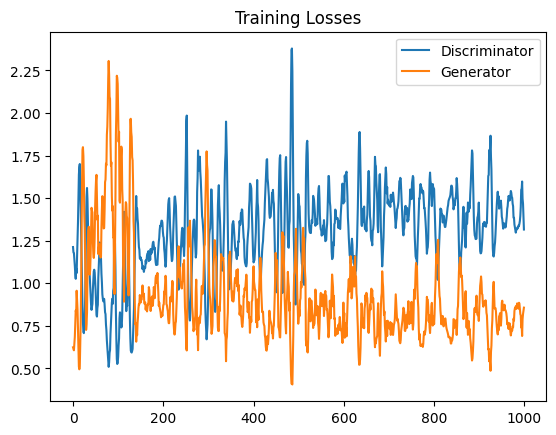

In [89]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Sampling from the generator

We can also get completely new images from the generator by using the checkpoint we saved after training. We just need to pass in a new latent vector $z$ and we'll get new samples!

In [92]:
saver = tf.compat.v1.train.Saver(var_list=g_vars)
with tf.compat.v1.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(
                   generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                   feed_dict={input_z: sample_z})
print((gen_samples * (data_offset + 50)) - data_offset)

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


2023-10-20 23:01:39.626487: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-20 23:01:39.626584: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-20 23:01:39.626608: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-20 23:01:39.626793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-20 23:01:39.626805: I tensorflow/core/co

[[  8.682228    17.79755      2.1943436   45.192604    37.114555
   46.444016    49.565758    11.502556    14.150215    -1.7918854
   14.691681    42.814445    23.111916    -2.1748505 ]
 [  3.4394684   12.230896     0.41418839  37.50837     18.378391
   18.086021    44.534485     1.837101     0.28922653 -10.216249
    6.8291206   23.85511     13.110474   -10.179426  ]
 [ -1.7887573   10.110424     1.3673782   34.19847     30.494164
   38.76007     46.537872    10.23975      7.3511963   -9.300552
   13.342495    31.407097    16.652306     3.3045654 ]
 [  6.416008    21.314934     3.0014648   44.969894    30.001389
   34.346237    48.556747    13.046841     5.495682    -9.475126
   15.027756    33.774414    21.349144    -6.7053146 ]
 [  7.092739    16.717873     9.24929     41.357796    24.00721
   40.40496     49.126152    12.819454     5.536232     0.12566757
   13.850151    31.960396    21.20697      2.8866882 ]
 [  4.6654854   12.6256485    7.2545624   36.54007     24.949097
   40.59